# 0. Install and Import Dependencies

In [10]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       2.0.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.9.0
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
altair                        5.2.0
anaconda-anon-usage           0.4.3
anaconda-catalogs             0.2.0
anaconda-client               1.11.3
anaconda-cloud-auth           0.1.4
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
archspec                      0.2.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy    

In [11]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [12]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [13]:
tf.config.list_physical_devices('GPU')

[]

In [14]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [15]:
import gdown

In [16]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [37]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [18]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [19]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [20]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [21]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [22]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [38]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [24]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [42]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [26]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [43]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

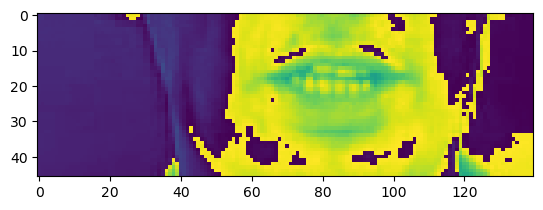

In [46]:
plt.imshow(frames[40])

In [29]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [30]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [47]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [48]:
from matplotlib import pyplot as plt

In [49]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [50]:
len(test)

50

In [54]:
# import os

# file_path = 'data/alignments/s1/'

# if os.path.exists(file_path):
#     print(f"The file '{file_path}' exists.")
# else:
#     print(f"The file '{file_path}' does not exist.")



In [65]:
frames, alignments = data.as_numpy_iterator().next()

ValueError: Attempt to convert a value (<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>) to a Tensor.

In [39]:
len(frames)

75

In [40]:
sample = data.as_numpy_iterator()

In [41]:
val = sample.next(); val[0]

OpenCV: Couldn't read video stream from file "data/s1/.mpg"
[ERROR:1@75.401] global cap.cpp:166 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): data/s1/.mpg in function 'icvExtractPattern'


2024-04-02 00:08:15.575405: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'
Traceback (most recent call last):

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'
Traceback (most recent call last):

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_65681/3912287231.py", line 9, in load_data
    alignments = load_alignments(alignment_path)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_65681/885867866.py", line 2, in load_alignments
    with open(path, 'r') as f:
        ^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 286, in _modified_open
    return io_open(file, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

2024-04-02 00:08:15.635108: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'
Traceback (most recent call last):

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/v

In [ ]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

NameError: name 'val' is not defined

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

NameError: name 'val' is not defined

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

NameError: name 'val' is not defined

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

OpenCV: Couldn't read video stream from file "data/s1/.mpg"
[ERROR:13@2181.231] global cap.cpp:166 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): data/s1/.mpg in function 'icvExtractPattern'


2024-04-01 23:59:32.229245: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'
Traceback (most recent call last):

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'
Traceback (most recent call last):

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_64665/3912287231.py", line 9, in load_data
    alignments = load_alignments(alignment_path)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_64665/885867866.py", line 2, in load_alignments
    with open(path, 'r') as f:
        ^^^^^^^^^^^^^^^

  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 286, in _modified_open
    return io_open(file, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/.align'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
5*17*75

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'444iiiiiiiiiiiiiimmmmmmmmmmmmmmmmmmmmmmiiiiiiiiiiimmmmmmmmiiiiiiiiiiixxxxxx'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'444iiiiiiiiiiiiiimmmmmmmmmmmmmmmmmmmmmmiiiiiiiiiiimmmmmmmmiiiiiiiiiiixxxxxx'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  2/450 [..............................] - ETA: 3:03 - loss: 213.9969 


KeyboardInterrupt



# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 973ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 720ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]